
# CUNY 620 Web Analytics - Summer 2021 Final Project

### Desciption

We intend to examine data pertaining to S&P 500 companies and their relationship between sectors, headquarters, sentiments and financial performance we will use both text and network analysis, below are the steps we are taking to tackel this project.

•	Collect the data from web scraping.

•	Create network analysis.

•	Focus on the top nodes in terms of headquarters, implementation of island method.

•	Create sector projection, to predict the sector for each name.

•	Implement sentimental analysis for the news articles, reviews for the positive, negative and, neutral sentiments

•	Visualize animated map based on the year and headquarter of each company.

**<a href="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies">By Wikipedia: </a> The S&P 500 stock market index, maintained by S&P Dow Jones Indices, comprises 505 common stocks issued by 500 large-cap companies and traded on American stock exchanges (including the 30 companies that compose the Dow Jones Industrial Average), and covers about 80 percent of the American equity market by capitalization. The index is weighted by free-float market capitalization, so more valuable companies account for relatively more of the index. The index constituents and the constituent weights are updated regularly using rules published by S&P Dow Jones Indices. Although called the S&P 500, the index contains 505 stocks because it includes two share classes of stock from 5 of its component companies.**


### Loading the data
WE are using multiple sources of data:

1- Getting the list of SP 500 companies from <a href="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies">Wikipedia</a>  using webscraping 

2- Getting the weight of the companies from<a href="https://www.slickcharts.com/sp500"> Slickcharts</a> and saving the data in Github

3- 


In [118]:
# Loading the required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import warnings
from networkx.algorithms import bipartite as bi


# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

#reading the renaming the columns
wiki = first_table
wiki.columns = ['Symbol', 'Security', 'filings', 'Sector', 'Sub_Industry', 'Headquarters', 'Date_added', 'CIK', 'Founded']
wiki.head()

,Symbol,Security,filings,Sector,Sub_Industry,Headquarters,Date_added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [5]:
# Split the city and state and create new column for state
wiki['State'] = wiki['Headquarters'].apply(lambda x: x.split(',')[1] if ',' in x else '')

wiki[0:5]

,Symbol,Security,filings,Sector,Sub_Industry,Headquarters,Date_added,CIK,Founded,State
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,Minnesota
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,Illinois
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),Illinois
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981,Massachusetts
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,Ireland


In [6]:
# We notice all of the empty values in State column are related to New York City
wiki['State'] = wiki['State'].str.strip()
wiki['State'] = wiki['State'].replace('', 'New York')

In [7]:
# Get the weights 
weights=pd.read_csv('https://raw.githubusercontent.com/akarimhammoud/DATA-620/main/Week_6_final%20project/weights.csv')
weights.drop(['#', 'Company', 'Chg', '% Chg'], axis='columns', inplace=True)
weights.head()

,Symbol,Weight,Price
0,AAPL,6.151855,145.08
1,MSFT,5.720618,277.85
2,AMZN,4.379672,"3,716.00"
3,FB,2.267526,350.60
4,GOOGL,2.059196,"2,508.49"


In [8]:
# Merge both datasets
df = pd.merge(wiki, weights, on ='Symbol', how ='inner')
df.head()

,Symbol,Security,filings,Sector,Sub_Industry,Headquarters,Date_added,CIK,Founded,State,Weight,Price
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,Minnesota,0.313848,201.00
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,Illinois,0.580172,119.74
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),Illinois,0.561722,116.58
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981,Massachusetts,0.040224,324.77
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,Ireland,0.538042,312.62


In [15]:
#Network nodes
G = nx.Graph()
G = nx.from_pandas_edgelist(df, source= 'State', target='Sector',edge_attr=True)

#add the attributes
nx.set_node_attributes(G, df['Weight'], 'Weight')
nx.set_node_attributes(G, df['Sub_Industry'], 'Sub_Industry')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 58
Number of edges: 205
Average degree:   7.0690


In [113]:
# Number of connected components
nx.number_connected_components(G)

1

In [114]:
# Check if its connected
nx.is_connected(G)

True

In [115]:
# top degree Headquarters
sector = list(df.Sector.unique())
state = list(df.State.unique())
headquarter = list(df.Headquarters.unique())

#The weight
gd=pd.DataFrame(G.degree(state)).sort_values(1,ascending =False).rename({0:'State:',1:'DEGREE'}, axis=1).set_index("State:")
print("Degree: \n", gd[0:10])

Degree: 
               DEGREE
State:              
California        11
New York          11
Texas             11
Pennsylvania       9
Illinois           9
Ohio               9
Minnesota          7
Florida            7
Connecticut        7
Georgia            7


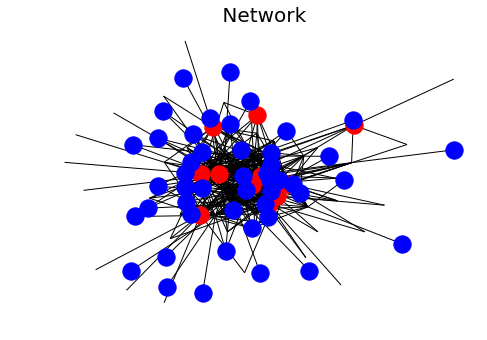

In [117]:
#visualize the network of sectors and states
nx.draw(G, nodelist = sector, node_color = 'red')
nx.draw(G, nodelist = state, node_color = 'blue')
plt.title(' Network', fontsize = 20, color = 'black')
plt.show()

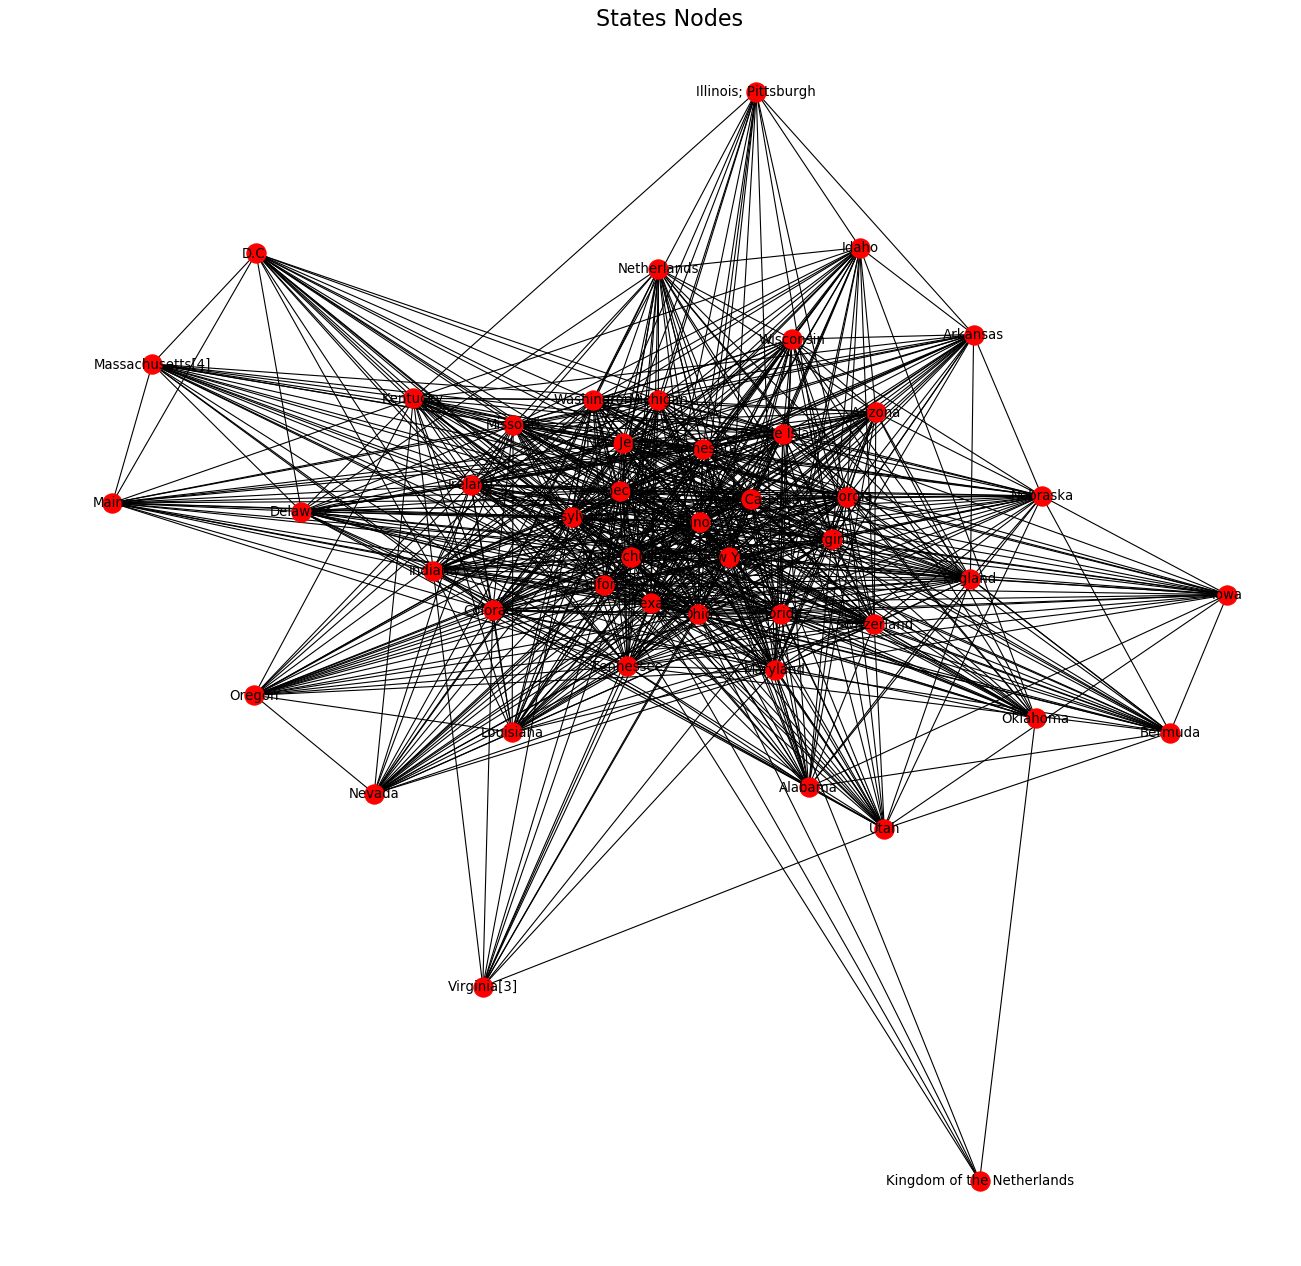

In [119]:
# create an affiliation network
netstate = bi.weighted_projected_graph(G, state)
netsector = bi.weighted_projected_graph(G, sector)

#Visualize entire  network of states
pos = nx.spring_layout(netstate)
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
nx.draw_networkx_nodes(netstate,pos, node_color = 'r')
nx.draw_networkx_edges(netstate,pos, node_color = 'r')
nx.draw_networkx_labels(netstate,pos)
plt.title('States Nodes',size = 20)

cut = 1.00
plt.show()

# Centrality Measures for States

In [120]:
# Top degrees per States
gd=pd.DataFrame(G.degree(state)).sort_values(1,ascending =False).rename({0:'Sector:',1:'DEGREE'}, axis=1).set_index("Sector:")
print("Degree: \n", gd[0:8])

Degree: 
               DEGREE
Sector:             
California        11
New York          11
Texas             11
Pennsylvania       9
Illinois           9
Ohio               9
Minnesota          7
Florida            7


In [121]:
#closeness
closeness = nx.closeness_centrality(netstate)
sorted(closeness.items(), key=lambda kv: (-kv[1], kv[0]))[0:8]

[('California', 1.0),
 ('New York', 1.0),
 ('Ohio', 1.0),
 ('Texas', 1.0),
 ('Illinois', 0.9787234042553191),
 ('Massachusetts', 0.9583333333333334),
 ('Pennsylvania', 0.9583333333333334),
 ('Connecticut', 0.9387755102040817)]

In [122]:
#betweenness
betweenness = nx.betweenness_centrality(netstate)
sorted(betweenness.items(), key=lambda kv: (-kv[1], kv[0]))[0:8]

[('California', 0.0232608657442817),
 ('New York', 0.0232608657442817),
 ('Ohio', 0.0232608657442817),
 ('Texas', 0.0232608657442817),
 ('Illinois', 0.014227049319160924),
 ('Massachusetts', 0.01204358865743939),
 ('Pennsylvania', 0.0114316429005661),
 ('Minnesota', 0.010172363520969943)]

In [123]:
#eigenvector
eigenvector = nx.eigenvector_centrality(netstate)
sorted(eigenvector.items(), key=lambda kv: (-kv[1], kv[0]))[0:8]

[('California', 0.17928941604582532),
 ('New York', 0.17928941604582532),
 ('Ohio', 0.17928941604582532),
 ('Texas', 0.17928941604582532),
 ('Illinois', 0.17867799732131623),
 ('Pennsylvania', 0.1770627985825197),
 ('Massachusetts', 0.1767096396118024),
 ('Connecticut', 0.17509444087300585)]

In [124]:
# Count the number of companies per state
count = df.groupby('State').count()
count1 = count.iloc[:, 0]
count1.sort_values(ascending=False)[0:8]

State
California       74
New York         55
Texas            40
Illinois         34
Massachusetts    22
Ohio             19
Pennsylvania     18
Georgia          17
Name: Symbol, dtype: int64

# Island Method for States

In [125]:
## islands method

# Trim Edges
def trim_edges(g, weight = 1):
    edges = []
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight']> weight:
            x = float(edata['weight'])
            edges.append((f,to,x))
    g2.add_weighted_edges_from(edges)
    return g2

# Island Method
def island_method(g, iterations=5):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    
    #size of step
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

In [132]:
# States
# Setup the graph
G1 = nx.Graph(name = "State")

# Get nodes for Sector ans States
node_values = list(df.Sector.values) + list(df.State.values)

# Add nodes 
G1.add_nodes_from(node_values) 


# Add edges
subset = df[['Sector', 'State', 'Weight']]
edges_tuples = [tuple(x) for x in subset.values]
G1.add_weighted_edges_from(edges_tuples)


# Setup the weights
weights = [float(edata['weight']) for f, t, edata in G1.edges(data=True)]


In [131]:
# Setup bipartite network for the states
state_graph = bi.weighted_projected_graph(G1, list(df.State.values), ratio=False)

# Add the components of subgraphs 
state_graph = list(nx.connected_component_subgraphs(state_graph))[0]

In [83]:
# Check the number of edges
state_graph.number_of_edges()

791

In [133]:
# Check the number of nodes
state_graph.number_of_nodes()

47

In [134]:
# Run teh island method
state_island = island_method(state_graph)

In [135]:
# Prind the data
print ("Threshold, Nodes, Edges, Number of Connected Components")
for i in state_island:
    print (i[0], nx.number_of_nodes(i[1]), nx.number_of_edges(i[1]), nx.number_connected_components(i[1]))

Threshold, Nodes, Edges, Number of Connected Components
1 37 461 1
3 25 209 1
5 18 83 1
7 6 14 1
9 3 3 1


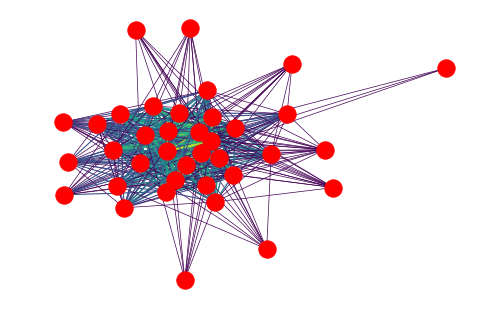

In [87]:
# Visualize the first graph for states
import  math
state_weights = [math.log(float(edata['weight'])) for f, t, edata in state_island[0][1].edges(data=True)]
nx.draw_spring(state_island[0][1], width=state_weights, edge_color=state_weights, with_labels=False)

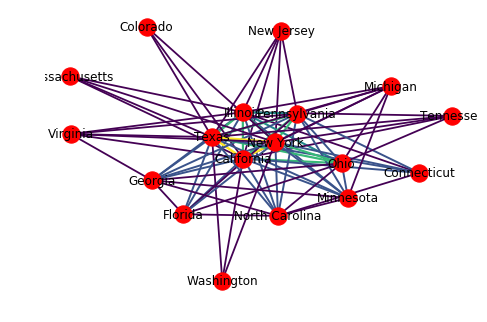

In [88]:
# Second Visualization for island method 
state_weights = [math.log(float(edata['weight'])) for f, t, edata in state_island[2][1].edges(data=True)]
nx.draw_spring(state_island[2][1], width=state_weights, edge_color=state_weights, with_labels=True)


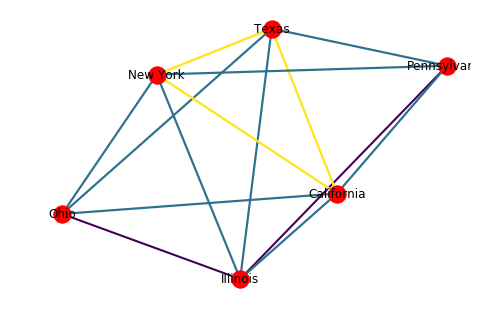

In [136]:
# Third Visualization for island method 
state_weights = [math.log(float(edata['weight'])) for f, t, edata in state_island[3][1].edges(data=True)]
nx.draw_spring(state_island[3][1], width=state_weights, edge_color=state_weights, with_labels=True)

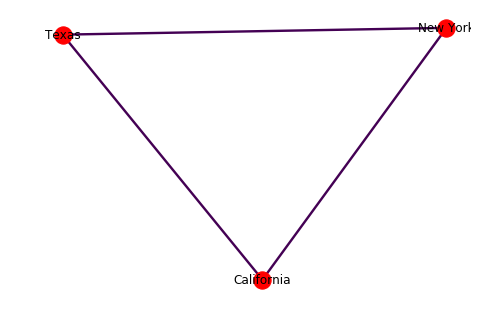

In [137]:
# Last Visualization for island method 
state_weights = [math.log(float(edata['weight'])) for f, t, edata in state_island[4][1].edges(data=True)]
nx.draw_spring(state_island[4][1], width=state_weights, edge_color=state_weights, with_labels=True)


## Conclusion for Island Method on the States/Countries of SP 500
From the last graph we can conclude the US with its top three states are having the highest weight on the SP 500 index, These major states and the companies in them play a major role of the SP 500 movements.

# Centrality Measures for Sectors

In [75]:
# Top degrees
gd=pd.DataFrame(G.degree(sector)).sort_values(1,ascending =False).rename({0:'Sector:',1:'DEGREE'}, axis=1).set_index("Sector:")
print("Degree: \n", gd[0:8])

Degree: 
                         DEGREE
Sector:                       
Industrials                 27
Consumer Discretionary      26
Financials                  24
Health Care                 23
Information Technology      22
Utilities                   19
Materials                   19
Consumer Staples            17


In [76]:
#closeness
closeness = nx.closeness_centrality(netsector)
sorted(closeness.items(), key=lambda kv: (-kv[1], kv[0]))[0:8]

[('Communication Services', 1.0),
 ('Consumer Discretionary', 1.0),
 ('Consumer Staples', 1.0),
 ('Energy', 1.0),
 ('Financials', 1.0),
 ('Health Care', 1.0),
 ('Industrials', 1.0),
 ('Information Technology', 1.0)]

In [77]:
#betweenness
betweenness = nx.betweenness_centrality(netsector)
sorted(betweenness.items(), key=lambda kv: (-kv[1], kv[0]))[0:8]

[('Communication Services', 0.0),
 ('Consumer Discretionary', 0.0),
 ('Consumer Staples', 0.0),
 ('Energy', 0.0),
 ('Financials', 0.0),
 ('Health Care', 0.0),
 ('Industrials', 0.0),
 ('Information Technology', 0.0)]

In [78]:
#eigenvector
eigenvector = nx.eigenvector_centrality(netsector)
sorted(eigenvector.items(), key=lambda kv: (-kv[1], kv[0]))[0:8]

[('Communication Services', 0.30151134457776363),
 ('Consumer Discretionary', 0.30151134457776363),
 ('Consumer Staples', 0.30151134457776363),
 ('Energy', 0.30151134457776363),
 ('Financials', 0.30151134457776363),
 ('Health Care', 0.30151134457776363),
 ('Industrials', 0.30151134457776363),
 ('Information Technology', 0.30151134457776363)]

In [79]:
# Count the number of companies per state
count = df.groupby('Sector').count()
count1 = count.iloc[:, 0]
count1.sort_values(ascending=False)[0:8]

Sector
Information Technology    74
Industrials               74
Financials                65
Health Care               64
Consumer Discretionary    63
Consumer Staples          32
Real Estate               29
Utilities                 28
Name: Symbol, dtype: int64

# Island Method for States

In [90]:
# Sectors
G2 = nx.Graph(name = "Sector")

# Add the nodes
G2.add_nodes_from(node_values) 


# Add the edges
subset = df[['Sector', 'State', 'Weight']]
edges_tuples = [tuple(x) for x in subset.values]
G2.add_weighted_edges_from(edges_tuples)


# The for G2
weights = [float(edata['weight']) for f, t, edata in G2.edges(data=True)]


In [93]:
# Setup bipartite network for the states
sector_graph = bi.weighted_projected_graph(G1, list(df.Sector.values), ratio=False)

In [95]:
# States
sector_graph = list(nx.connected_component_subgraphs(sector_graph))[0]

In [96]:
# Check the number of edges
sector_graph.number_of_edges()

55

In [138]:
# Check the number of nodes
sector_graph.number_of_nodes()

11

In [139]:
# Setup the island method for sectors
sector_island = island_method(sector_graph)

In [140]:
# Pring the data
print ("Threshold, Nodes, Edges, Number of Connected Components")
for i in sector_island:
    print (i[0], nx.number_of_nodes(i[1]), nx.number_of_edges(i[1]), nx.number_connected_components(i[1]))

Threshold, Nodes, Edges, Number of Connected Components
3 11 54 1
6 10 38 1
9 9 30 1
12 8 19 1
15 6 8 1
18 3 2 1


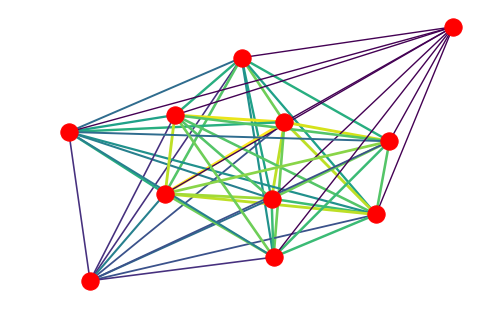

In [101]:
# First run of Island Method
import  math
sector_weights = [math.log(float(edata['weight'])) for f, t, edata in sector_island[0][1].edges(data=True)]
nx.draw_spring(sector_island[0][1], width=sector_weights, edge_color=sector_weights, with_labels=False)


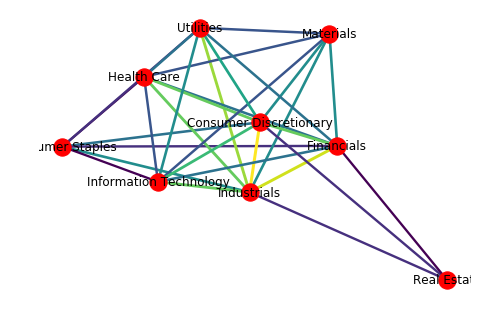

In [102]:
# Second run of Island Method
sector_weights = [math.log(float(edata['weight'])) for f, t, edata in sector_island[2][1].edges(data=True)]
nx.draw_spring(sector_island[2][1], width=sector_weights, edge_color=sector_weights, with_labels=True)


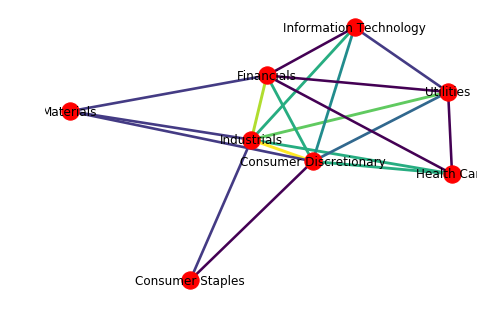

In [111]:
# Third run of Island Method
sector_weights = [math.log(float(edata['weight'])) for f, t, edata in sector_island[3][1].edges(data=True)]
nx.draw_spring(sector_island[3][1], width=sector_weights, edge_color=sector_weights, with_labels=True)

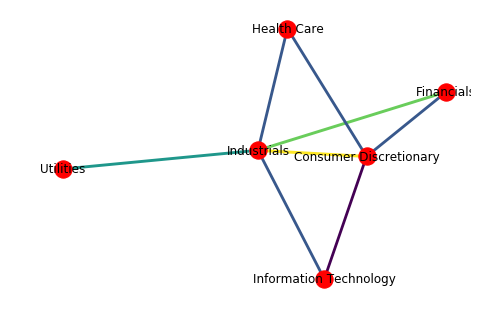

In [112]:
# Fourth run of Island Method
sector_weights = [math.log(float(edata['weight'])) for f, t, edata in sector_island[4][1].edges(data=True)]
nx.draw_spring(sector_island[4][1], width=sector_weights, edge_color=sector_weights, with_labels=True)


## Conclusion for Island Method on the Sectors of SP 500
From the last graph we can conclude the industrials, consumers, IT, healthcare, Utilities, and Financial as the highest weighted in the SP 500 index, so whatever happens in these secotrs it effects the entier SP 500 index as the majority of the companies work in these companies.